# GDP Application: Brexit Analysis (Robustness Check, treatment time is 2020Q1)

This notebook implements the synthetic control and relaxed balancing methods to analyze the economic impact of Brexit on the UK's GDP growth. The treatment time is set as 2020Q1 in this notebook. 

To exactly replicate the empirical results from the original paper, a licensed MOSEK solver [https://www.mosek.com/] is required. Alternatively, you may use other compatible solvers available through CVXPY.

## Setup and Import 

In [1]:
import scmrelax # import our package

print(scmrelax.__version__)

0.1.0


In [2]:
## Setup and Imports
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import scmrelax  # import our package

# Set plotting style
plt.style.use('seaborn-v0_8-paper')
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Suppress warnings
warnings.filterwarnings("ignore")

## Data Loading and Preprocessing

In [3]:
# Read the preprocessed data
GDP = pd.read_csv('balanced_GDP_data.csv', index_col=0, parse_dates=True)

# Calculate GDP growth rate
GDP_growth = 100*GDP.pct_change(4).dropna()

# Prepare UK data for visualization
GDP_UK = pd.Series(GDP['United Kingdom'], index=GDP_growth.index) / 1000000  # Convert to trillions
GDP_growth_UK = pd.Series(GDP_growth['United Kingdom'], index=GDP_growth.index)

# Define the function to prepare the data
def prepare_data(GDP_growth, target_country, pre_treat_date):
    """Prepare data for synthetic control analysis."""
    y = GDP_growth[target_country]
    X = GDP_growth.drop(target_country, axis=1)
    
    y_pre = y.loc[:pre_treat_date]
    X_pre = X.loc[:pre_treat_date]
    country_list = X_pre.columns
    
    return (y.to_numpy(), X.to_numpy(), 
            y_pre.to_numpy(), X_pre.to_numpy(), 
            country_list)

# Prepare data for analysis
target_country = 'United Kingdom'
pre_treat_q = '2020-01-01'
treat_q = '2020-03-31'

y, X, y_pre, X_pre, country_list = prepare_data(
    GDP_growth, target_country, pre_treat_q
)

print("Pre-treatment periods, Donor pool size: ", X_pre.shape)

Pre-treatment periods, Donor pool size:  (65, 57)


## Weight Estimation

In [4]:
# Estimate weights
results = scmrelax.fit(X_pre, y_pre, X)

## Weight Comparison

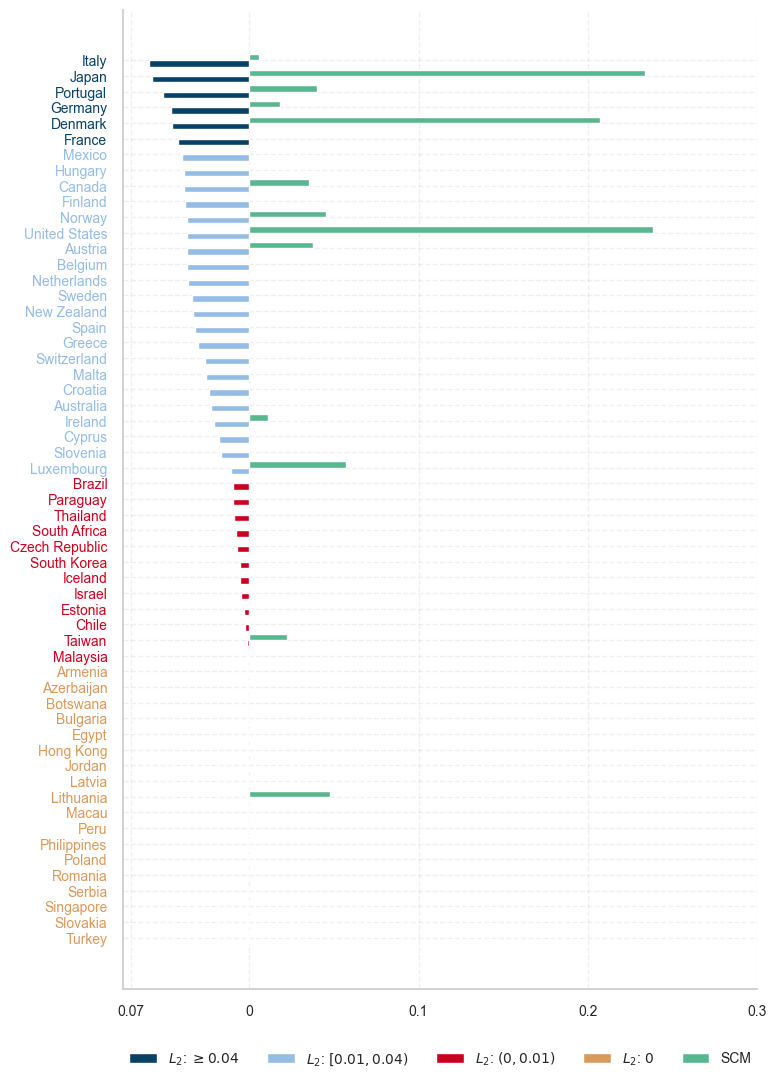

In [5]:
def create_weight_comparison_histogram(results, country_list):
    """Create a vertical histogram comparing SCM and L2 weights."""
    # Get weights and create DataFrame
    weights_df = pd.DataFrame({
        'Country': country_list,
        'SCM': results['scm']['weights'],
        'L2': results['l2']['weights']
    })
    
    # Split the data into zero and non-zero weights
    zero_weights = weights_df[weights_df['L2'] < 0.0001].sort_values('Country', ascending=False)
    non_zero_weights = weights_df[weights_df['L2'] >= 0.0001].sort_values('L2', ascending=True)
    
    # Combine the dataframes
    weights_df = pd.concat([zero_weights, non_zero_weights])
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 11))
    
    # Set the width of bars and spacing
    bar_width = 1.2
    spacing = 2
    
    # Set positions of the bars
    r1 = np.arange(len(weights_df)) * (1 + spacing)
    r2 = [x + bar_width for x in r1]
    
    # Define colors for different weight groups
    color_group1 = '#074166'  # For weights > 0.04
    color_group2 = '#95BCE5'  # For weights 0.01-0.04
    color_group3 = '#CC011F'  # For weights 0-0.01
    color_group4 = '#D9995B'  # For weights exactly 0
    
    # Create the bars
    for i, (scm_weight, l2_weight) in enumerate(zip(weights_df['SCM'], weights_df['L2'])):
        if l2_weight > 0.04:
            l2_color = color_group1
        elif l2_weight > 0.01:
            l2_color = color_group2
        elif l2_weight > 0.0001: # 0.0001 is the threshold for zero weights because the existence of numerical error
            l2_color = color_group3
        else:
            l2_color = color_group4
            
        ax.barh(r1[i], -l2_weight, height=bar_width, color=l2_color)
        ax.barh(r2[i], scm_weight, height=bar_width, color='#59B78F')

    # Set x-axis ticks
    ax.set_xticks([-0.07, 0.0, 0.1, 0.2, 0.3])
    ax.set_xticklabels(['0.07', '0', '0.1', '0.2', '0.3'], fontsize=10)

    # Add labels
    tick_positions = [r + bar_width/2 for r in r1]
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(weights_df['Country'], fontsize=10)

    # Color the y-axis labels
    for i, label in enumerate(ax.get_yticklabels()):
        country = label.get_text()
        l2_weight = weights_df.loc[weights_df['Country'] == country, 'L2'].values[0]
        if l2_weight > 0.04:
            label.set_color(color_group1)
        elif l2_weight > 0.01:
            label.set_color(color_group2)
        elif l2_weight > 0.0001:
            label.set_color(color_group3)
        else:
            label.set_color(color_group4)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=color_group1, label='$L_2$: $\\geq 0.04$'),
        Patch(facecolor=color_group2, label='$L_2$: $[0.01, 0.04)$'),
        Patch(facecolor=color_group3, label='$L_2$: $(0, 0.01)$'),
        Patch(facecolor=color_group4, label='$L_2$: $0$'),
        Patch(facecolor='#59B78F', label='SCM')
    ]
    
    ax.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=5,
        fontsize=10,
        frameon=True,
        facecolor='white',
        edgecolor='none'
    )
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create the comparison histogram
create_weight_comparison_histogram(results, country_list)

## Fitted Growth Rate Analysis

In [6]:
# Calculate in-sample empirical risks
treatment_time = y_pre.shape[0]
ER_scm = np.mean((results['scm']['predictions'][:treatment_time] - y_pre)**2)
ER_EL = np.mean((results['EL']['predictions'][:treatment_time] - y_pre)**2)
ER_entropy = np.mean((results['entropy']['predictions'][:treatment_time] - y_pre)**2)
ER_l2 = np.mean((results['l2']['predictions'][:treatment_time] - y_pre)**2)

print("In Sample Empirical Risks:")
print(f"SCM: {ER_scm:.4f}")
print(f"EL-SCM-Relaxation: {ER_EL:.4f}")
print(f"Entropy-SCM-Relaxation: {ER_entropy:.4f}")
print(f"L2-SCM-Relaxation: {ER_l2:.4f}")

In Sample Empirical Risks:
SCM: 0.6231
EL-SCM-Relaxation: 1.2329
Entropy-SCM-Relaxation: 1.1489
L2-SCM-Relaxation: 1.1919


## Plot the Gap between Realized Growth Rate and Fitted Values

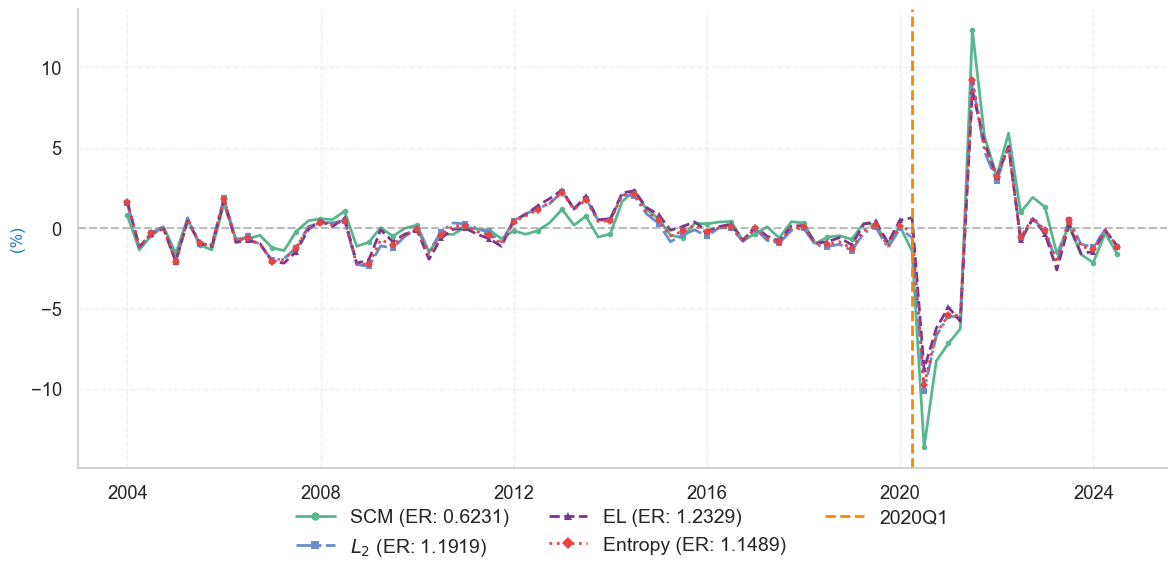

In [7]:
## Gap between realized growth rate and fitted growth rate
# define some colors
color_SCM = '#59B78F'
color_L2 = '#6A8EC9'
color_EL = '#7A378A'
color_entropy = '#E84446'
color_real = '#1f77b4'
# Convert to time series
y = pd.Series(y, index=GDP_growth.index)
y_fit_scm = pd.Series(results['scm']['predictions'], index=GDP_growth.index)
y_fit_EL = pd.Series(results['EL']['predictions'], index=GDP_growth.index)
y_fit_entropy = pd.Series(results['entropy']['predictions'], index=GDP_growth.index)
y_fit_l2 = pd.Series(results['l2']['predictions'], index=GDP_growth.index)

# Create figure with style guide settings
plt.figure(figsize=(12, 6))

# Plot all differences with enhanced distinction
# SCM: solid line with markers
plt.plot(y-y_fit_scm, color=color_SCM, label=f'SCM (ER: {round(ER_scm, 4)})', 
         linewidth=2, linestyle='-', marker='o', markersize=4, markevery=2)

# L2: dash-dot line with squares
plt.plot(y-y_fit_l2, color=color_L2, label=f'$L_2$ (ER: {round(ER_l2, 4)})', 
         linewidth=2, linestyle='-.', marker='s', markersize=4, markevery=2)

# EL: dashed line with triangles
plt.plot(y-y_fit_EL, color=color_EL, label=f'EL (ER: {round(ER_EL, 4)})', 
         linewidth=2, linestyle='--', marker='^', markersize=4, markevery=2)

# Entropy: dotted line with diamonds
plt.plot(y-y_fit_entropy, color=color_entropy, label=f'Entropy (ER: {round(ER_entropy, 4)})', 
         linewidth=2, linestyle=':', marker='D', markersize=4, markevery=2)


# Add y-axis label
plt.ylabel('(%)', fontsize=12, color = '#1f77b4')

# Add treatment line
treatment_date = GDP_growth.index[treatment_time]
color_treatment = '#FB8500'
plt.axvline(x=treatment_date, color=color_treatment, linestyle='--', label='2020Q1', linewidth=2)

# Add zero line
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.5)

# Add legend with enhanced visibility
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    fontsize=14,
    frameon=True,
    facecolor='white',
    edgecolor='none',
    markerscale=1.5  # Make markers larger in legend
)

# Add grid with reduced opacity
plt.grid(True, linestyle='--', alpha=0.3)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


## GDP extrapolation

In [8]:
def extrapolate_GDP(GDP_series, growth_rate_series, pre_treatment_date = '2019-12-31'):
    """
    Extrapolate GDP values using growth rates.
    
    Args:
        GDP_series (pd.Series): Original GDP series
        growth_rate_series (pd.Series): Growth rate series for extrapolation
        treatment_date (str): Treatment date in 'YYYY-MM-DD' format
    
    Returns:
        pd.Series: Extrapolated GDP series
    """
    # Create a copy of the original GDP series
    GDP_extrapolated = GDP_series.copy()
    
    # Get the pre-treatment GDP values (4 quarters before treatment)
    pre_treatment_GDP = GDP_series.loc[:pre_treatment_date].iloc[-4:]
    
    # Initialize post-treatment GDP array
    post_treatment_GDP = np.zeros(len(growth_rate_series))
    
    # Calculate post-treatment GDP values
    for i in range(len(growth_rate_series)):
        if i < 4:
            # For first 4 quarters, use pre-treatment GDP values
            post_treatment_GDP[i] = pre_treatment_GDP.iloc[i] * (1 + growth_rate_series.iloc[i]/100)
        else:
            # For later quarters, use previous year's GDP
            post_treatment_GDP[i] = post_treatment_GDP[i-4] * (1 + growth_rate_series.iloc[i]/100)
    
    # Update the GDP series with extrapolated values
    GDP_extrapolated.loc[growth_rate_series.index] = post_treatment_GDP
    
    return GDP_extrapolated

# Get the UK GDP data
GDP_bre = GDP['United Kingdom']

# Get growth rates for different methods
growth_rates = {
    'original': GDP_growth_UK.loc[treat_q:],
    'scm': y_fit_scm[treatment_time:],
    'EL': y_fit_EL[treatment_time:],
    'entropy': y_fit_entropy[treatment_time:],
    'l2': y_fit_l2[treatment_time:]
}

# Extrapolate GDP for each method
GDP_extrapolated = {}
for method, growth_rate in growth_rates.items():
    GDP_extrapolated[method] = extrapolate_GDP(
        GDP_bre, 
        growth_rate,
        pre_treat_q
    )

# Store results in separate variables for backward compatibility
GDP_bre_original = GDP_extrapolated['original']
GDP_bre_scm = GDP_extrapolated['scm']
GDP_bre_EL = GDP_extrapolated['EL']
GDP_bre_entropy = GDP_extrapolated['entropy']
GDP_bre_l2 = GDP_extrapolated['l2']

## Plot the Gap between Realized GDP and Fitted Values

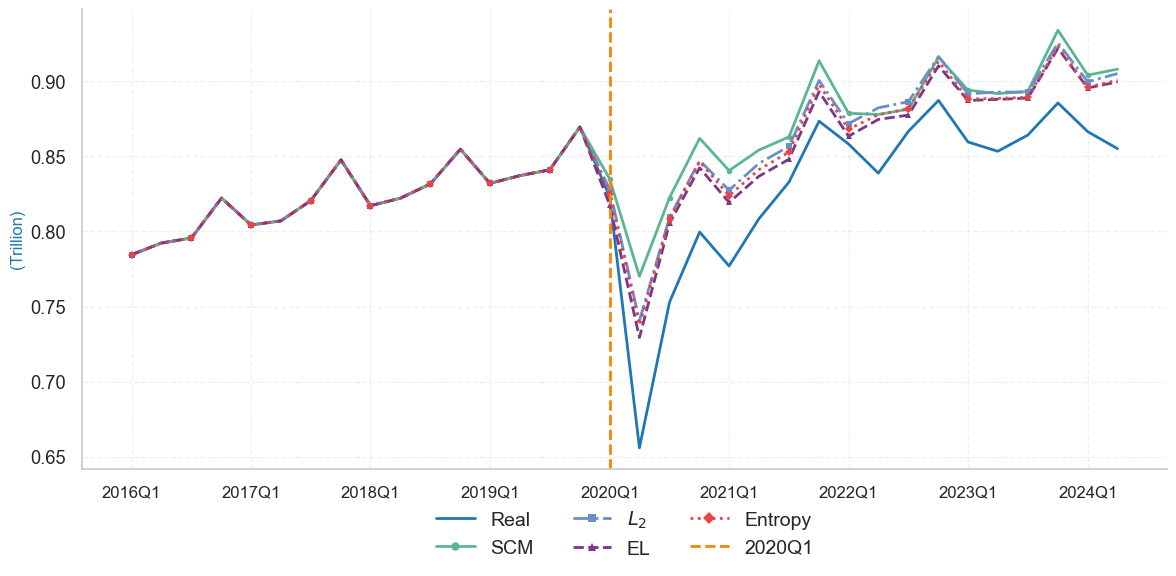

In [9]:
## Plot the GDP and fitted GDP of the UK
def plot_GDP_comparison(GDP_original, GDP_scm, GDP_EL, GDP_entropy, GDP_l2, treatment_date, start_date='2016-03-31'):
    """
    Plot comparison of real and extrapolated GDP values.
    
    Args:
        GDP_original (pd.Series): Real GDP series
        GDP_scm (pd.Series): SCM extrapolated GDP
        GDP_EL (pd.Series): EL extrapolated GDP
        GDP_entropy (pd.Series): Entropy extrapolated GDP
        GDP_l2 (pd.Series): L2 extrapolated GDP
        treatment_date (str): Treatment date
        start_date (str): Start date for plotting
    """
    # Convert GDP from billion to trillion
    GDP_original = GDP_original / 1000000
    GDP_scm = GDP_scm / 1000000
    GDP_EL = GDP_EL / 1000000
    GDP_entropy = GDP_entropy / 1000000
    GDP_l2 = GDP_l2 / 1000000
    
    # Create figure with style guide settings
    plt.figure(figsize=(12, 6))
    
    # Plot GDP series with consistent colors and styles
    plt.plot(GDP_original[start_date:], label='Real', color=color_real, linewidth=2)
    plt.plot(GDP_scm[start_date:], label='SCM', color=color_SCM, linewidth=2, linestyle='-', marker='o', markersize=4, markevery=2)
    plt.plot(GDP_l2[start_date:], label='$L_2$', color=color_L2, linewidth=2, linestyle='-.', marker='s', markersize=4, markevery=2)
    plt.plot(GDP_EL[start_date:], label='EL', color=color_EL, linewidth=2, linestyle='--', marker='^', markersize=4, markevery=2)
    plt.plot(GDP_entropy[start_date:], label='Entropy', color=color_entropy, linewidth=2, linestyle=':', marker='D', markersize=4, markevery=2)
    
    # Set x-axis ticks to show only Q1 of each year
    ticks = [x for x in GDP_scm[start_date:].index if x.quarter == 1]
    labels = [f"{x.year}Q{x.quarter}" for x in ticks]
    plt.xticks(ticks, labels, fontsize=12)
    
    # Add treatment line
    plt.axvline(x=pd.to_datetime(treatment_date), linestyle='--', color=color_treatment, 
                linewidth=2, label='2020Q1')
    
    # Add labels and title

    plt.ylabel('(Trillion)', fontsize=12, color='#1f77b4')
    
    # Add legend with enhanced visibility
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=3,
        fontsize=14,
        frameon=True,
        facecolor='white',
        edgecolor='none',
        markerscale=1.5  # Make markers larger in legend
    )
    
    # Add grid with reduced opacity
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.show()

# Plot GDP comparison
plot_GDP_comparison(
    GDP_bre_original,
    GDP_bre_scm,
    GDP_bre_EL,
    GDP_bre_entropy,
    GDP_bre_l2,
    treat_q
)

## Calculate the ATEs as the Percentage of Total GDP after 2020Q1

In [10]:
## Calculate the ATE as the percentage of the real GDP after treatment
def calculate_ATE(GDP_real, GDP_scm, GDP_EL, GDP_entropy, GDP_l2, treatment_date):
    """
    Calculate Average Treatment Effect (ATE) as percentage and absolute value of real GDP.
    
    Args:
        GDP_real (pd.Series): Real GDP series
        GDP_scm (pd.Series): SCM extrapolated GDP
        GDP_EL (pd.Series): EL extrapolated GDP
        GDP_entropy (pd.Series): Entropy extrapolated GDP
        GDP_l2 (pd.Series): L2 extrapolated GDP
        treatment_date (str): Treatment date
    
    Returns:
        pd.DataFrame: DataFrame containing ATE results
    """
    # Calculate total GDP for the treatment period
    GDP_sum = GDP_real[treatment_date:].sum()
    
    # Calculate gaps
    gaps = {
        'SCM': np.sum(GDP_real[treatment_date:] - GDP_scm[treatment_date:]) / GDP_sum,
        'EL': np.sum(GDP_real[treatment_date:] - GDP_EL[treatment_date:]) / GDP_sum,
        'Entropy': np.sum(GDP_real[treatment_date:] - GDP_entropy[treatment_date:]) / GDP_sum,
        'L2': np.sum(GDP_real[treatment_date:] - GDP_l2[treatment_date:]) / GDP_sum
    }
    
    # Calculate absolute values
    abs_gaps = {
        'SCM': np.mean(GDP_real[treatment_date:] - GDP_scm[treatment_date:])/1e6,
        'EL': np.mean(GDP_real[treatment_date:] - GDP_EL[treatment_date:])/1e6,
        'Entropy': np.mean(GDP_real[treatment_date:] - GDP_entropy[treatment_date:])/1e6,
        'L2': np.mean(GDP_real[treatment_date:] - GDP_l2[treatment_date:])/1e6
    }
    
    # Create DataFrame
    results_df = pd.DataFrame({
        'Method': list(gaps.keys()),
        'ATE (%)': [round(gap * 100, 4) for gap in gaps.values()],  # Convert to percentage
        'ATE (Trillion)': [round(gap, 4) for gap in abs_gaps.values()]  # Original GDP gap
    })
    
    # Print results
    print("\nAverage Treatment Effect (ATE):")
    print(results_df.to_string(index=False))

    
    return results_df

# Calculate and save ATE
ATE_results = calculate_ATE(
    GDP_bre,
    GDP_bre_scm,
    GDP_bre_EL,
    GDP_bre_entropy,
    GDP_bre_l2,
    treat_q
)


Average Treatment Effect (ATE):
 Method  ATE (%)  ATE (Trillion)
    SCM  -5.2248         -0.0434
     EL  -3.6111         -0.0300
Entropy  -4.0213         -0.0334
     L2  -4.4189         -0.0367
